In [69]:
import os
import sys
import random 

import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from functools import partial
import matplotlib.pyplot as plt 

sys.path.append("..")

from IPython import display

# %load_ext autoreload
# %autoreload 2

## Download datasets

In [70]:
mnist = torchvision.datasets.MNIST("../datasets", train=True, download=True)
cifar10 = torchvision.datasets.CIFAR10("../datasets", download=True)
cifar100 = torchvision.datasets.CIFAR100("../datasets", download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

## Test

In [77]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = CIFAR10(root='../datasets', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = CIFAR10(root='../datasets', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [79]:
# get some random training images
dataiter = iter(testloader)
images, target = dataiter.next()

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, target = dataiter.next()

# show images
print(images)
# imshow(torchvision.utils.make_grid(images))

tensor([[[[-0.5686, -0.5608, -0.5686,  ..., -0.6392, -0.6392, -0.6235],
          [-0.5922, -0.5843, -0.5843,  ..., -0.6157, -0.6157, -0.6235],
          [-0.5922, -0.5922, -0.5843,  ..., -0.6000, -0.6078, -0.6235],
          ...,
          [-0.0980, -0.0588, -0.0118,  ..., -0.0275, -0.0431, -0.0431],
          [ 0.0039,  0.0275,  0.0353,  ..., -0.0039, -0.0275, -0.0431],
          [ 0.1059,  0.1294,  0.1373,  ...,  0.0118, -0.0039, -0.0275]],

         [[-0.5059, -0.4980, -0.5059,  ..., -0.5608, -0.5608, -0.5529],
          [-0.5216, -0.5216, -0.5137,  ..., -0.5373, -0.5373, -0.5451],
          [-0.5216, -0.5137, -0.5059,  ..., -0.5216, -0.5294, -0.5373],
          ...,
          [-0.0039,  0.0275,  0.0510,  ...,  0.0196,  0.0039,  0.0039],
          [ 0.0353,  0.0588,  0.0588,  ...,  0.0275,  0.0039, -0.0118],
          [ 0.1137,  0.1451,  0.1529,  ...,  0.0353,  0.0196, -0.0039]],

         [[-0.2078, -0.2000, -0.2078,  ..., -0.3255, -0.3255, -0.3255],
          [-0.2549, -0.2471, -

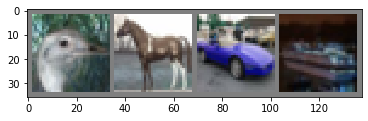

In [68]:
imshow(torchvision.utils.make_grid(target))